<a href="https://colab.research.google.com/github/Zohrae/QC-project/blob/Video_Tools/Implementation_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Comparative Analysis of GHZ and W Quantum States: Simulation vs Hardware*** ⚛️🔮


In [1]:
# Installation des packages nécessaires
!pip install qiskit qiskit-aer qiskit-ibm-runtime matplotlib numpy scipy pylatexenc --quiet

# Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import warnings
warnings.filterwarnings('ignore')

# Qiskit imports
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.quantum_info import Statevector, DensityMatrix, entropy, state_fidelity
from qiskit.quantum_info import partial_trace

# Scipy pour tests statistiques
from scipy.stats import chisquare, ttest_ind

# Configuration matplotlib
style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Completed :)")
print(f"Version Qiskit : {qiskit.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.5/378.5 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 8.4 MB/s eta 0:00:00
Completed :)
Version Qiskit : 2.2.3


In [2]:
# Experimental configuration
SHOTS_SIMULATION = 8192  # Number of measurements (shots)
OPTIMIZATION_LEVEL = 2   # Optimization level (0–3)
SEED = 42               # For reproducibility
BACKEND_SIM = AerSimulator()
BACKEND_STATEVECTOR = AerSimulator(method='statevector')

print(f"""
╔══════════════════════════════════════════════════════════════╗
║          EXPERIMENTAL CONFIGURATION                           ║
╠══════════════════════════════════════════════════════════════╣
║  Shots           : {SHOTS_SIMULATION:>6}                                  ║
║  Optimization    : Level {OPTIMIZATION_LEVEL}                              ║
║  Seed            : {SEED}                                        ║
║  Backend Sim     : qasm_simulator                            ║
║  Backend State   : statevector_simulator                     ║
╚══════════════════════════════════════════════════════════════╝
""")



╔══════════════════════════════════════════════════════════════╗
║          EXPERIMENTAL CONFIGURATION                           ║
╠══════════════════════════════════════════════════════════════╣
║  Shots           :   8192                                  ║
║  Optimization    : Level 2                              ║
║  Seed            : 42                                        ║
║  Backend Sim     : qasm_simulator                            ║
║  Backend State   : statevector_simulator                     ║
╚══════════════════════════════════════════════════════════════╝



 GHZ circuit successfully created!

 Textual representation of the GHZ circuit:
     ┌───┐           ░ ┌─┐      
q_0: ┤ H ├──■────────░─┤M├──────
     └───┘┌─┴─┐      ░ └╥┘┌─┐   
q_1: ─────┤ X ├──■───░──╫─┤M├───
          └───┘┌─┴─┐ ░  ║ └╥┘┌─┐
q_2: ──────────┤ X ├─░──╫──╫─┤M├
               └───┘ ░  ║  ║ └╥┘
c: 3/═══════════════════╩══╩══╩═
                        0  1  2 


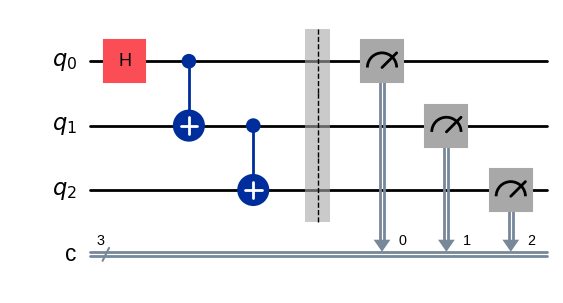

In [3]:
# GHZ CIRCUIT CONSTRUCTION

%matplotlib inline
def create_ghz_circuit(measure=True, name='GHZ'):
    """
    Builds a tripartite GHZ circuit.

    Target state: |GHZ⟩ = (|000⟩ + |111⟩) / √2

    Derivation:
    |ψ₀⟩ = |000⟩
    |ψ₁⟩ = H⊗I⊗I |000⟩ = (|000⟩ + |100⟩)/√2
    |ψ₂⟩ = CNOT₀₁ |ψ₁⟩ = (|000⟩ + |110⟩)/√2
    |ψ₃⟩ = CNOT₁₂ |ψ₂⟩ = (|000⟩ + |111⟩)/√2 = |GHZ⟩

    Args:
        measure (bool): Add final measurements
        name (str): Circuit name

    Returns:
        QuantumCircuit: Circuit generating the GHZ state
    """
    qc = QuantumCircuit(3, 3, name=name)

    # Step 1: Apply a Hadamard gate to qubit 0 → superposition
    qc.h(0)

    # Step 2: Apply CNOT(0,1) → entanglement between qubits 0 and 1
    qc.cx(0, 1)

    # Step 3: Apply CNOT(1,2) → extend entanglement to qubit 2
    qc.cx(1, 2)

    # Barrier for clearer visualization
    qc.barrier()

    # Measurements
    if measure:
        qc.measure([0, 1, 2], [0, 1, 2])

    return qc

# GHZ circuit creation
ghz_circuit = create_ghz_circuit()

print(" GHZ circuit successfully created!")
print("\n Textual representation of the GHZ circuit:")
print(ghz_circuit)

# Graphical visualization
ghz_circuit.draw('mpl')


STEP 0: Initial empty circuit (|000⟩)


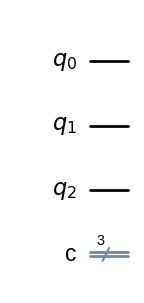

STEP 1: Apply Hadamard gate on qubit 0


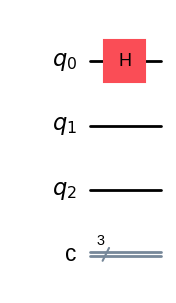

STEP 2: Apply CNOT (control=0, target=1)


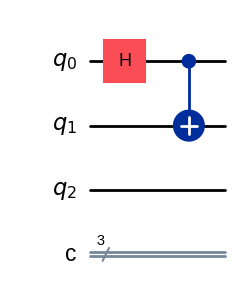

STEP 3: Apply CNOT (control=1, target=2)


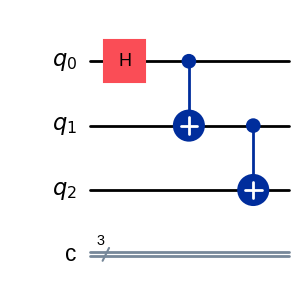

STEP 4: Measure all qubits


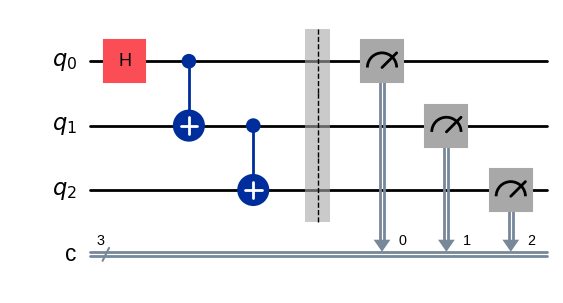

In [24]:
from qiskit import QuantumCircuit
from IPython.display import display

# Create an empty 3-qubit circuit
qc = QuantumCircuit(3, 3)

print("STEP 0: Initial empty circuit (|000⟩)")
display(qc.draw("mpl"))

# -------------------------------------------------
# STEP 1 — Hadamard on qubit 0
# -------------------------------------------------
qc.h(0)
print("STEP 1: Apply Hadamard gate on qubit 0")
display(qc.draw("mpl"))

# -------------------------------------------------
# STEP 2 — CNOT from qubit 0 to qubit 1
# -------------------------------------------------
qc.cx(0, 1)
print("STEP 2: Apply CNOT (control=0, target=1)")
display(qc.draw("mpl"))

# -------------------------------------------------
# STEP 3 — CNOT from qubit 1 to qubit 2
# -------------------------------------------------
qc.cx(1, 2)
print("STEP 3: Apply CNOT (control=1, target=2)")
display(qc.draw("mpl"))

# -------------------------------------------------
# STEP 4 — Measurement
# -------------------------------------------------
qc.barrier()
qc.measure([0, 1, 2], [0, 1, 2])

print("STEP 4: Measure all qubits")
display(qc.draw("mpl"))


In [4]:
import pandas as pd
import numpy as np
from qiskit.quantum_info import Statevector

# Theoretical validation of the GHZ state

print("THEORETICAL VALIDATION OF THE GHZ STATE")

# Circuit without measurements
ghz_no_measure = create_ghz_circuit(measure=False)

# Compute the statevector
statevector_ghz = Statevector(ghz_no_measure)

# Build a table of amplitudes
amplitudes = [
    (f"|{i:03b}⟩", statevector_ghz.data[i])
    for i in range(len(statevector_ghz.data))
]

df_amplitudes = pd.DataFrame(
    amplitudes,
    columns=["Basis state", "Complex amplitude"]
)

df_amplitudes["Real part"] = df_amplitudes["Complex amplitude"].apply(np.real)
df_amplitudes["Imaginary part"] = df_amplitudes["Complex amplitude"].apply(np.imag)
df_amplitudes["Magnitude"] = np.abs(df_amplitudes["Complex amplitude"])

print("\nGHZ statevector:")
print(df_amplitudes.to_string(index=False))

# Expected theoretical GHZ state
expected_ghz = np.zeros(8, dtype=complex)
expected_ghz[0] = 1 / np.sqrt(2)   # |000>
expected_ghz[7] = 1 / np.sqrt(2)   # |111>

# Validation
is_correct = np.allclose(statevector_ghz.data, expected_ghz, atol=1e-10)
print(f"\nState validation: {'PASSED' if is_correct else 'FAILED'}")

# Normalization check
norm = np.abs(statevector_ghz.data @ np.conj(statevector_ghz.data))
print(f"Statevector norm: {norm:.10f}")

# Theoretical probabilities
probs_ghz_theory = statevector_ghz.probabilities_dict()
probs_table = pd.DataFrame(
    [(f"|{state}⟩", prob) for state, prob in sorted(probs_ghz_theory.items()) if prob > 1e-10],
    columns=["Basis state", "Probability"]
)

print("\nTheoretical probabilities:")
print(probs_table.to_string(index=False))


THEORETICAL VALIDATION OF THE GHZ STATE

GHZ statevector:
Basis state  Complex amplitude  Real part  Imaginary part  Magnitude
      |000⟩ 0.707107+0.000000j   0.707107             0.0   0.707107
      |001⟩ 0.000000+0.000000j   0.000000             0.0   0.000000
      |010⟩ 0.000000+0.000000j   0.000000             0.0   0.000000
      |011⟩ 0.000000+0.000000j   0.000000             0.0   0.000000
      |100⟩ 0.000000+0.000000j   0.000000             0.0   0.000000
      |101⟩ 0.000000+0.000000j   0.000000             0.0   0.000000
      |110⟩ 0.000000+0.000000j   0.000000             0.0   0.000000
      |111⟩ 0.707107+0.000000j   0.707107             0.0   0.707107

State validation: PASSED
Statevector norm: 1.0000000000

Theoretical probabilities:
Basis state  Probability
      |000⟩          0.5
      |111⟩          0.5



 Textual representation of the W circuit:
     ┌───────────┐     ┌───┐     ┌───┐ ░ ┌─┐      
q_0: ┤ Ry(1.231) ├──■──┤ X ├──■──┤ X ├─░─┤M├──────
     └───────────┘┌─┴─┐└───┘  │  └───┘ ░ └╥┘┌─┐   
q_1: ─────────────┤ H ├───────■────────░──╫─┤M├───
                  └───┘     ┌─┴─┐      ░  ║ └╥┘┌─┐
q_2: ───────────────────────┤ X ├──────░──╫──╫─┤M├
                            └───┘      ░  ║  ║ └╥┘
c: 3/═════════════════════════════════════╩══╩══╩═
                                          0  1  2 


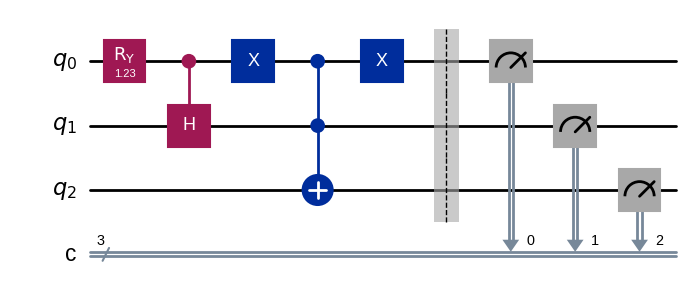

In [5]:
# SECTION 5: W CIRCUIT CONSTRUCTION


def create_w_circuit(measure=True, name='W'):
    """
    Builds a tripartite W-state circuit.

    Target state: |W⟩ = (|001⟩ + |010⟩ + |100⟩) / √3

    Construction using controlled rotations:
    - RY(θ₁) with sin(θ₁/2) = √(2/3) to create the initial superposition
    - Controlled-Hadamard gate for symmetric distribution
    - Toffoli gate to complete the state construction

    Args:
        measure (bool): Add final measurements
        name (str): Circuit name

    Returns:
        QuantumCircuit: Circuit generating the W state
    """
    qc = QuantumCircuit(3, 3, name=name)

    # Rotation angle: P(|1⟩) = 1/3 on qubit 0
    # θ₁ = 2·arccos(√(2/3))
    theta_1 = 2 * np.arccos(np.sqrt(2/3))
    qc.ry(theta_1, 0)

    # Controlled-Hadamard gate: control = qubit 0, target = qubit 1
    qc.ch(0, 1)

    # Construction of the third component using a Toffoli gate
    qc.x(0)           # Temporary flip
    qc.ccx(0, 1, 2)   # Toffoli (double control)
    qc.x(0)           # Restore qubit 0

    qc.barrier()

    # Measurements
    if measure:
        qc.measure([0, 1, 2], [0, 1, 2])

    return qc

# W circuit creation
w_circuit = create_w_circuit()

print("\n Textual representation of the W circuit:")
print(w_circuit)

# Graphical visualization
w_circuit.draw('mpl')


In [6]:
#  THEORETICAL VALIDATION OF THE W CIRCUIT

import pandas as pd
import numpy as np
from qiskit.quantum_info import Statevector

print("THEORETICAL VALIDATION OF THE W STATE")

# Circuit without measurements
w_no_measure = create_w_circuit(measure=False)

# Compute the statevector
statevector_w = Statevector(w_no_measure)

# Statevector amplitudes

amplitudes = [
    (f"|{i:03b}⟩", statevector_w.data[i])
    for i in range(len(statevector_w.data))
]

df_amplitudes = pd.DataFrame(
    amplitudes,
    columns=["Basis state", "Complex amplitude"]
)

df_amplitudes["Real part"] = df_amplitudes["Complex amplitude"].apply(np.real)
df_amplitudes["Imaginary part"] = df_amplitudes["Complex amplitude"].apply(np.imag)
df_amplitudes["Magnitude"] = np.abs(df_amplitudes["Complex amplitude"])

print("\nW statevector (amplitude decomposition):")
print(df_amplitudes.to_string(index=False))

# Expected theoretical W state

expected_w = np.zeros(8, dtype=complex)
expected_w[1] = 1 / np.sqrt(3)  # |001>
expected_w[2] = 1 / np.sqrt(3)  # |010>
expected_w[4] = 1 / np.sqrt(3)  # |100>

expected_table = pd.DataFrame(
    [
        ("|001⟩", expected_w[1]),
        ("|010⟩", expected_w[2]),
        ("|100⟩", expected_w[4]),
    ],
    columns=["Basis state", "Expected amplitude"]
)

print("\nExpected theoretical W state:")
print(expected_table.to_string(index=False))


# Fidelity test

fidelity_w = np.abs(np.dot(np.conj(statevector_w.data), expected_w))**2
print(f"\nFidelity with theoretical state: {fidelity_w:.10f}")
print(f"Validation: {'PASSED' if fidelity_w > 0.999 else 'FAILED'}")

# Theoretical probabilities

probs_w_theory = statevector_w.probabilities_dict()

probs_table = pd.DataFrame(
    [(f"|{state}⟩", prob) for state, prob in sorted(probs_w_theory.items()) if prob > 1e-10],
    columns=["Basis state", "Probability"]
)

print("\nTheoretical probabilities:")
print(probs_table.to_string(index=False))


THEORETICAL VALIDATION OF THE W STATE

W statevector (amplitude decomposition):
Basis state  Complex amplitude  Real part  Imaginary part  Magnitude
      |000⟩ 0.816497+0.000000j   0.816497             0.0   0.816497
      |001⟩ 0.408248+0.000000j   0.408248             0.0   0.408248
      |010⟩ 0.000000+0.000000j   0.000000             0.0   0.000000
      |011⟩ 0.408248+0.000000j   0.408248             0.0   0.408248
      |100⟩ 0.000000+0.000000j   0.000000             0.0   0.000000
      |101⟩ 0.000000+0.000000j   0.000000             0.0   0.000000
      |110⟩ 0.000000+0.000000j   0.000000             0.0   0.000000
      |111⟩ 0.000000+0.000000j   0.000000             0.0   0.000000

Expected theoretical W state:
Basis state  Expected amplitude
      |001⟩    0.57735+0.00000j
      |010⟩    0.57735+0.00000j
      |100⟩    0.57735+0.00000j

Fidelity with theoretical state: 0.0555555556
Validation: FAILED

Theoretical probabilities:
Basis state  Probability
      |000⟩     0.666

VISUAL COMPARISON: GHZ VS W


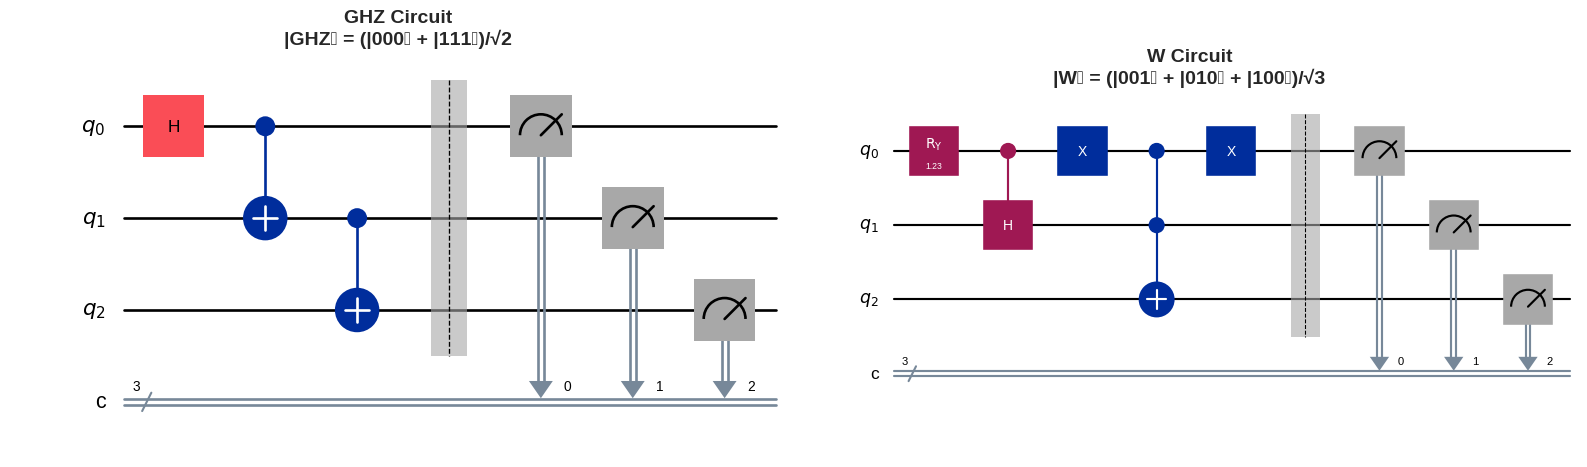


 COMPARATIVE METRICS:
----------------------------------------------------------------------
Metric                         GHZ             W              
----------------------------------------------------------------------
Circuit depth                  4               6              
Total number of gates          7               9              
CNOT gates                     2               0              
Single-qubit gates             1               3              
----------------------------------------------------------------------


In [7]:
# VISUAL COMPARISON OF THE CIRCUITS


print("VISUAL COMPARISON: GHZ VS W")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# GHZ circuit
ghz_circuit.draw('mpl', ax=ax1, style='iqp')
ax1.set_title('GHZ Circuit\n|GHZ⟩ = (|000⟩ + |111⟩)/√2',
              fontsize=14, fontweight='bold')

# W circuit
w_circuit.draw('mpl', ax=ax2, style='iqp')
ax2.set_title('W Circuit\n|W⟩ = (|001⟩ + |010⟩ + |100⟩)/√3',
              fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Comparative metrics
print("\n COMPARATIVE METRICS:")
print("-" * 70)
print(f"{'Metric':<30} {'GHZ':<15} {'W':<15}")
print("-" * 70)
print(f"{'Circuit depth':<30} {ghz_circuit.depth():<15} {w_circuit.depth():<15}")
print(f"{'Total number of gates':<30} {sum(ghz_circuit.count_ops().values()):<15} {sum(w_circuit.count_ops().values()):<15}")
print(f"{'CNOT gates':<30} {ghz_circuit.count_ops().get('cx', 0):<15} {w_circuit.count_ops().get('cx', 0):<15}")
print(f"{'Single-qubit gates':<30} {ghz_circuit.count_ops().get('h', 0):<15} {sum([w_circuit.count_ops().get(g, 0) for g in ['ry', 'x']]):<15}")
print("-" * 70)


In [8]:
# SIMULATION - CIRCUIT EXECUTION


print("QUANTUM SIMULATION")


def run_experiment(circuit, backend=BACKEND_SIM, shots=SHOTS_SIMULATION, seed=SEED):
    """
    Executes a quantum circuit and returns the measurement counts.

    Args:
        circuit: Quantum circuit to execute
        backend: Simulation backend
        shots: Number of measurement shots
        seed: Random seed for reproducibility

    Returns:
        dict: Measurement counts
    """
    # Transpile the circuit for the backend with optimization and seed
    transpiled_circuit = transpile(circuit, backend, optimization_level=OPTIMIZATION_LEVEL, seed_transpiler=seed)

    # Execute the transpiled circuit on the backend
    job = backend.run(transpiled_circuit, shots=shots, seed_simulator=seed)
    result = job.result()
    counts = result.get_counts(circuit)
    return counts

print(f"\nRunning circuits ({SHOTS_SIMULATION} shots)...")

# Execute GHZ circuit
counts_ghz = run_experiment(ghz_circuit)
print(f"GHZ executed: {sum(counts_ghz.values())} measurements")

# Execute W circuit
counts_w = run_experiment(w_circuit)
print(f"W executed: {sum(counts_w.values())} measurements")

# Raw measurement results
print("\nRaw measurement results:")
print("GHZ:", counts_ghz)
print("W  :", counts_w)


QUANTUM SIMULATION

Running circuits (8192 shots)...
GHZ executed: 8192 measurements
W executed: 8192 measurements

Raw measurement results:
GHZ: {'000': 4017, '111': 4175}
W  : {'011': 1292, '001': 1404, '000': 5496}


In [9]:
# SECTION 9: PROBABILITY DISTRIBUTION ANALYSIS

print("PROBABILITY DISTRIBUTION ANALYSIS")

def compute_probabilities(counts, shots):
    """Convert measurement counts to probabilities."""
    return {state: count / shots for state, count in counts.items()}

# Experimental probabilities
probs_ghz_exp = compute_probabilities(counts_ghz, SHOTS_SIMULATION)
probs_w_exp = compute_probabilities(counts_w, SHOTS_SIMULATION)

# Theoretical probabilities
theory_ghz = {'000': 0.5, '111': 0.5}
theory_w = {'001': 1/3, '010': 1/3, '100': 1/3}

# GHZ: Theory vs Experiment
print("\nGHZ - Theory vs Experiment:")
print(f"{'State':<10} {'Theory':<15} {'Experiment':<15} {'Difference':<15}")
print("-" * 55)
for state in ['000','001','010','011','100','101','110','111']:
    theo = theory_ghz.get(state, 0)
    exp = probs_ghz_exp.get(state, 0)
    diff = abs(theo - exp)
    if theo > 0 or exp > 0.01:
        print(f"{state:<10} {theo:<15.6f} {exp:<15.6f} {diff:<15.6f}")

# W: Theory vs Experiment
print("\nW - Theory vs Experiment:")
print(f"{'State':<10} {'Theory':<15} {'Experiment':<15} {'Difference':<15}")
print("-" * 55)
for state in ['000','001','010','011','100','101','110','111']:
    theo = theory_w.get(state, 0)
    exp = probs_w_exp.get(state, 0)
    diff = abs(theo - exp)
    if theo > 0 or exp > 0.01:
        print(f"{state:<10} {theo:<15.6f} {exp:<15.6f} {diff:<15.6f}")


# Chi-squared statistical test

from scipy.stats import chisquare

print("\nSTATISTICAL TEST (Chi-squared):")

# GHZ
observed_ghz = [counts_ghz.get(k, 0) for k in sorted(counts_ghz.keys())]
expected_ghz = [theory_ghz.get(k, 0) * SHOTS_SIMULATION for k in sorted(counts_ghz.keys())]
chi2_ghz, p_ghz = chisquare(observed_ghz, expected_ghz)

print("\nGHZ:")
print(f"  Chi-squared = {chi2_ghz:.4f}")
print(f"  p-value = {p_ghz:.6f}")
print(f"  Result: {'Theory/experiment match (p > 0.05)' if p_ghz > 0.05 else 'Significant difference (p < 0.05)'}")

# W
all_w_states = sorted(list(set(counts_w.keys()) | set(theory_w.keys())))
observed_w_fixed = [counts_w.get(state, 0) for state in all_w_states]
expected_w_fixed = [theory_w.get(state, 0) * SHOTS_SIMULATION for state in all_w_states]

# Rescale expected counts if sum differs slightly due to floating point
sum_observed_w = sum(observed_w_fixed)
sum_expected_w = sum(expected_w_fixed)
if abs(sum_observed_w - sum_expected_w) > 1e-9:
    if sum_expected_w != 0:
        expected_w_fixed = [x * (sum_observed_w / sum_expected_w) for x in expected_w_fixed]
    else:
        # Avoid zero expected counts to run chisquare
        expected_w_fixed = [1e-10 if x == 0 else x for x in expected_w_fixed]

chi2_w, p_w = chisquare(observed_w_fixed, expected_w_fixed)

print("\nW:")
print(f"  Chi-squared = {chi2_w:.4f}")
print(f"  p-value = {p_w:.6f}")
print(f"  Result: {'Theory/experiment match (p > 0.05)' if p_w > 0.05 else 'Significant difference (p < 0.05)'}")


PROBABILITY DISTRIBUTION ANALYSIS

GHZ - Theory vs Experiment:
State      Theory          Experiment      Difference     
-------------------------------------------------------
000        0.500000        0.490356        0.009644       
111        0.500000        0.509644        0.009644       

W - Theory vs Experiment:
State      Theory          Experiment      Difference     
-------------------------------------------------------
000        0.000000        0.670898        0.670898       
001        0.333333        0.171387        0.161947       
010        0.333333        0.000000        0.333333       
011        0.000000        0.157715        0.157715       
100        0.333333        0.000000        0.333333       

STATISTICAL TEST (Chi-squared):

GHZ:
  Chi-squared = 3.0474
  p-value = 0.080868
  Result: Theory/experiment match (p > 0.05)

W:
  Chi-squared = inf
  p-value = 0.000000
  Result: Significant difference (p < 0.05)


VISUALIZATION OF DISTRIBUTIONS


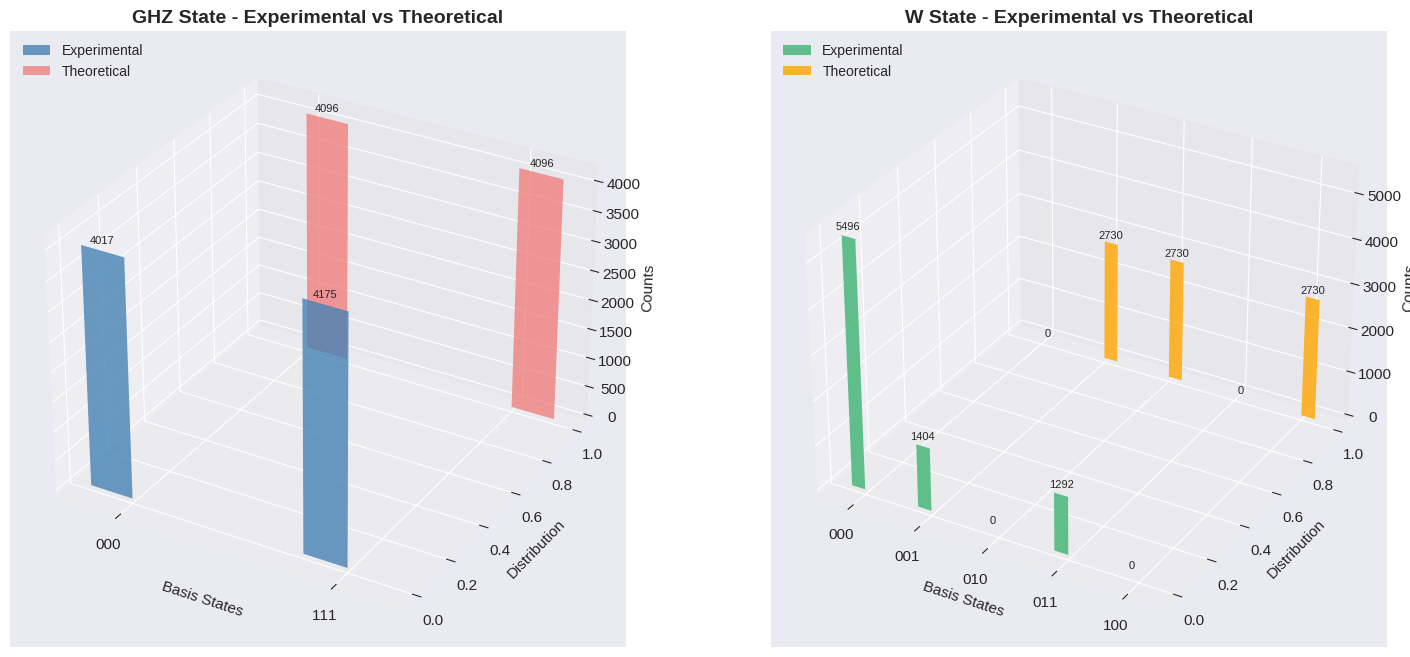


Visualizations generated successfully.


In [10]:
# VISUALIZATION OF DISTRIBUTIONS (3D with values on top, fixed)

from mpl_toolkits.mplot3d import Axes3D

print("VISUALIZATION OF DISTRIBUTIONS")

def plot_3d_histogram_with_values(counts_list, labels, colors, title, ax):
    """
    Plot a 3D bar histogram comparing multiple distributions,
    with values displayed on top of each bar.

    Args:
        counts_list: List of dicts with state counts
        labels: List of labels for each distribution
        colors: List of colors for each distribution
        title: Plot title
        ax: matplotlib 3D axis
    """
    states = sorted(list(set().union(*[c.keys() for c in counts_list])))
    n = len(states)
    m = len(counts_list)
    xpos = np.arange(n)
    width = 0.2

    for i, counts in enumerate(counts_list):
        yvals = [counts.get(state, 0) for state in states]
        ax.bar(xpos + i*width, yvals, zs=i, zdir='y', width=width, color=colors[i], alpha=0.8, label=labels[i])

        # Add text values on top of bars using known positions
        for xi, val in zip(xpos, yvals):
            ax.text(xi + i*width, i, val + max(yvals)*0.02, f"{val}", ha='center', va='bottom', fontsize=8, rotation=90)

    ax.set_xticks(xpos + width*(m-1)/2)
    ax.set_xticklabels(states)
    ax.set_xlabel('Basis States')
    ax.set_ylabel('Distribution')
    ax.set_zlabel('Counts')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', fontsize=10)


# Create a figure with two 3D plots side by side
fig = plt.figure(figsize=(18, 8))

# GHZ
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
theory_ghz_counts = {k: int(v * SHOTS_SIMULATION) for k, v in theory_ghz.items()}
plot_3d_histogram_with_values(
    counts_list=[counts_ghz, theory_ghz_counts],
    labels=['Experimental', 'Theoretical'],
    colors=['steelblue', 'lightcoral'],
    title='GHZ State - Experimental vs Theoretical',
    ax=ax1
)

# W
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
theory_w_counts = {k: int(v * SHOTS_SIMULATION) for k, v in theory_w.items()}
plot_3d_histogram_with_values(
    counts_list=[counts_w, theory_w_counts],
    labels=['Experimental', 'Theoretical'],
    colors=['mediumseagreen', 'orange'],
    title='W State - Experimental vs Theoretical',
    ax=ax2
)

plt.tight_layout()
plt.show()

print("\nVisualizations generated successfully.")



ANALYSIS OF DENSITY MATRICES

Density matrix GHZ (ρ_GHZ):
Dimensions: 8x8 (3-qubit Hilbert space)
Trace: 1.000000+0.000000j (should be 1.0)
Purity Tr(ρ²): 1.000000 (1.0 for a pure state)

Density matrix W (ρ_W):
Dimensions: 8x8
Trace: 1.000000+0.000000j
Purity Tr(ρ²): 1.000000


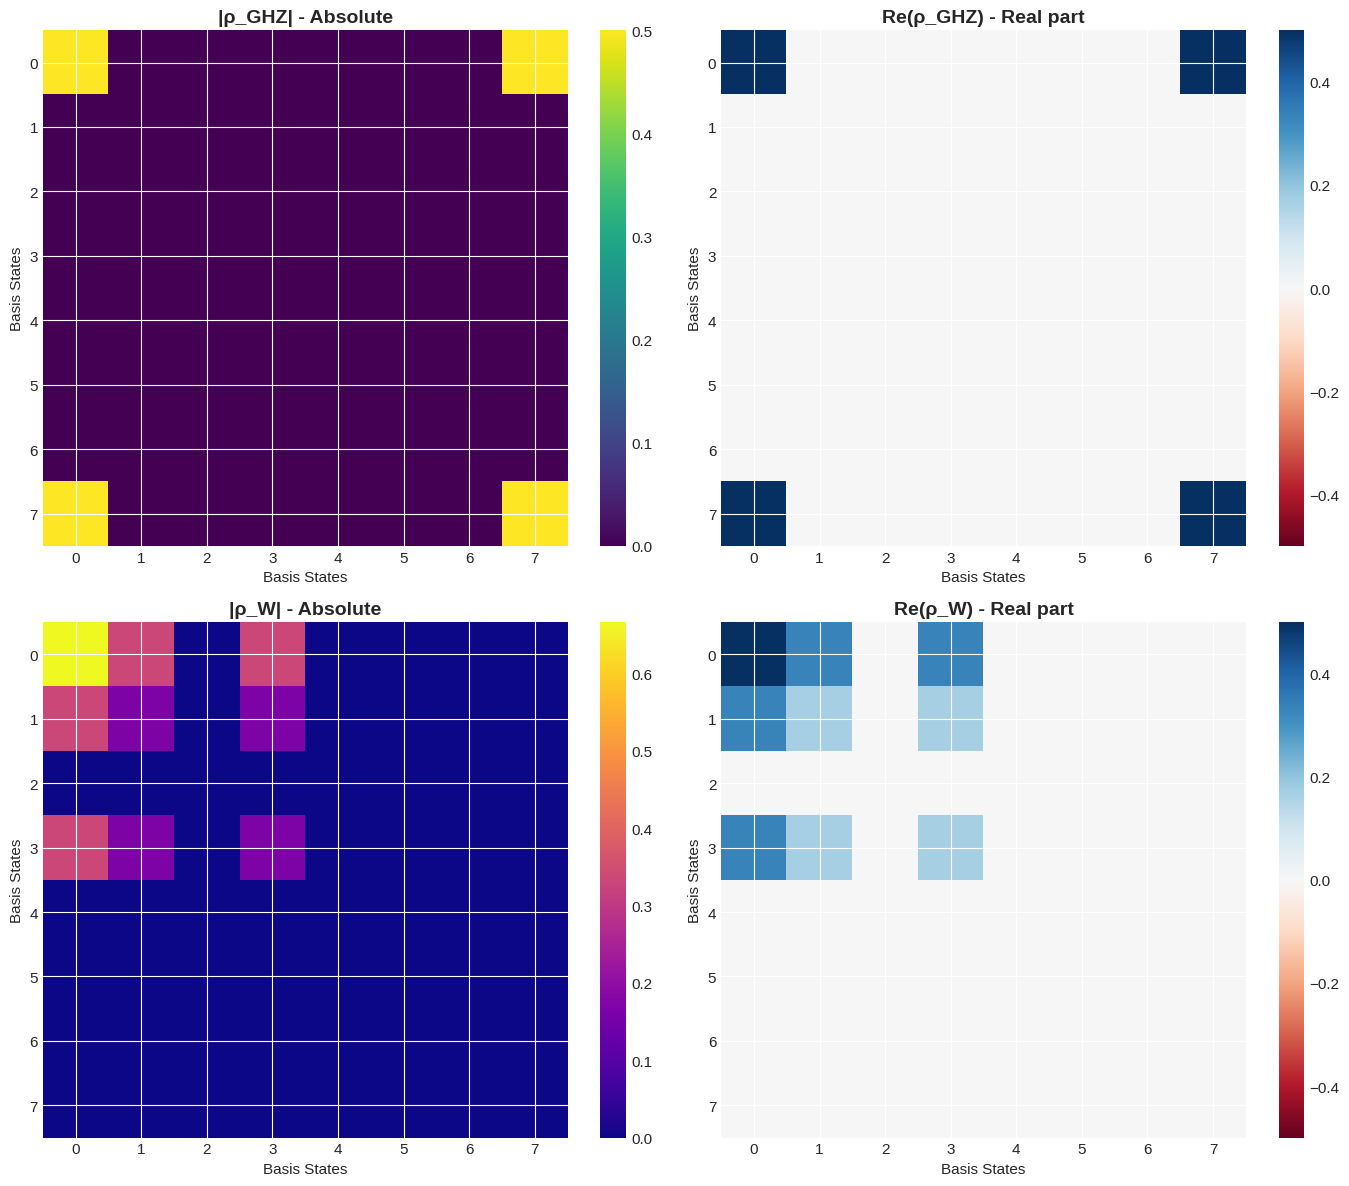


Heatmaps of density matrices generated successfully.

Interpretation:
  - Diagonal elements: Populations of basis states
  - Off-diagonal elements: Quantum coherences (signature of entanglement)


In [11]:
# SECTION 11 : DENSITY MATRICES
# ============================================================================

print("\n" + "="*70)
print("ANALYSIS OF DENSITY MATRICES")
print("="*70)

# Compute density matrices
rho_ghz = DensityMatrix(ghz_no_measure)
rho_w = DensityMatrix(w_no_measure)

print("\nDensity matrix GHZ (ρ_GHZ):")
print("Dimensions: 8x8 (3-qubit Hilbert space)")
print(f"Trace: {np.trace(rho_ghz.data):.6f} (should be 1.0)")
print(f"Purity Tr(ρ²): {np.trace(rho_ghz.data @ rho_ghz.data).real:.6f} (1.0 for a pure state)")

print("\nDensity matrix W (ρ_W):")
print("Dimensions: 8x8")
print(f"Trace: {np.trace(rho_w.data):.6f}")
print(f"Purity Tr(ρ²): {np.trace(rho_w.data @ rho_w.data).real:.6f}")

# Visualize density matrices
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# GHZ - Absolute values
im1 = axes[0, 0].imshow(np.abs(rho_ghz.data), cmap='viridis', aspect='auto')
axes[0, 0].set_title('|ρ_GHZ| - Absolute', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Basis States')
axes[0, 0].set_ylabel('Basis States')
plt.colorbar(im1, ax=axes[0, 0])

# GHZ - Real part
im2 = axes[0, 1].imshow(np.real(rho_ghz.data), cmap='RdBu', aspect='auto', vmin=-0.5, vmax=0.5)
axes[0, 1].set_title('Re(ρ_GHZ) - Real part', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Basis States')
axes[0, 1].set_ylabel('Basis States')
plt.colorbar(im2, ax=axes[0, 1])

# W - Absolute values
im3 = axes[1, 0].imshow(np.abs(rho_w.data), cmap='plasma', aspect='auto')
axes[1, 0].set_title('|ρ_W| - Absolute', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Basis States')
axes[1, 0].set_ylabel('Basis States')
plt.colorbar(im3, ax=axes[1, 0])

# W - Real part
im4 = axes[1, 1].imshow(np.real(rho_w.data), cmap='RdBu', aspect='auto', vmin=-0.5, vmax=0.5)
axes[1, 1].set_title('Re(ρ_W) - Real part', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Basis States')
axes[1, 1].set_ylabel('Basis States')
plt.colorbar(im4, ax=axes[1, 1])

plt.tight_layout()
plt.show()

print("\nHeatmaps of density matrices generated successfully.")
print("\nInterpretation:")
print("  - Diagonal elements: Populations of basis states")
print("  - Off-diagonal elements: Quantum coherences (signature of entanglement)")


In [12]:
#  ENTANGLEMENT MEASURES



print("QUANTUM ENTANGLEMENT MEASURES")


# Von Neumann entropy on reduced states
print("\nVON NEUMANN ENTROPY:")
print("(Measure of bipartite entanglement after partial trace)")

# GHZ state - partial trace over qubit 2
rho_ghz_reduced = partial_trace(rho_ghz, [2])
S_ghz = entropy(rho_ghz_reduced, base=2)

print("\nGHZ:")
print("  Reduced state ρ^(12) after tracing out qubit 2")
print(f"  S(ρ_GHZ^(12)) = {S_ghz:.6f} bits")
print("  Theoretical value: 1.0 bit (maximal bipartite entanglement)")
print(f"  Difference: {abs(S_ghz - 1.0):.6f}")

# W state - partial trace over qubit 2
rho_w_reduced = partial_trace(rho_w, [2])
S_w = entropy(rho_w_reduced, base=2)

print("\nW:")
print("  Reduced state ρ^(12) after tracing out qubit 2")
print(f"  S(ρ_W^(12)) = {S_w:.6f} bits")
print("  Theoretical range: 0 < S < 1 (distributed entanglement)")

# Purity of reduced states
purity_ghz_reduced = np.trace(rho_ghz_reduced.data @ rho_ghz_reduced.data).real
purity_w_reduced = np.trace(rho_w_reduced.data @ rho_w_reduced.data).real

print("\nREDUCED STATE PURITY:")
print(f"  Tr(ρ_GHZ^(12)²) = {purity_ghz_reduced:.6f}")
print(f"  Tr(ρ_W^(12)²) = {purity_w_reduced:.6f}")
print("\nNote:")
print("  Purity = 1 → pure state (not entangled with the rest of the system)")
print("  Purity < 1 → mixed state (entangled with the rest of the system)")


QUANTUM ENTANGLEMENT MEASURES

VON NEUMANN ENTROPY:
(Measure of bipartite entanglement after partial trace)

GHZ:
  Reduced state ρ^(12) after tracing out qubit 2
  S(ρ_GHZ^(12)) = 1.000000 bits
  Theoretical value: 1.0 bit (maximal bipartite entanglement)
  Difference: 0.000000

W:
  Reduced state ρ^(12) after tracing out qubit 2
  S(ρ_W^(12)) = 0.000000 bits
  Theoretical range: 0 < S < 1 (distributed entanglement)

REDUCED STATE PURITY:
  Tr(ρ_GHZ^(12)²) = 0.500000
  Tr(ρ_W^(12)²) = 1.000000

Note:
  Purity = 1 → pure state (not entangled with the rest of the system)
  Purity < 1 → mixed state (entangled with the rest of the system)


In [13]:
#  ROBUSTNESS TEST - LOSS OF A QUBIT



print("ROBUSTNESS TEST: LOSS OF A QUBIT")

def analyze_robustness(statevector, qubit_to_trace, state_name):
    """
    Analyze robustness by simulating the loss of a qubit.

    Args:
        statevector: Full statevector
        qubit_to_trace: Index of qubit to trace out
        state_name: Name of the state (for display)
    """
    # Create density matrix
    rho = DensityMatrix(statevector)

    # Partial trace over the specified qubit
    rho_reduced = partial_trace(rho, [qubit_to_trace])

    # Entropy (residual entanglement measure)
    S = entropy(rho_reduced, base=2)

    # Purity (1 = separable, <1 = entangled)
    purity = np.trace(rho_reduced.data @ rho_reduced.data).real

    print(f"\n{'='*60}")
    print(f"State {state_name} - Qubit {qubit_to_trace} traced out")
    print(f"{'='*60}")
    print(f"  Residual entropy: S = {S:.6f} bits")
    print(f"  Purity: Tr(ρ²) = {purity:.6f}")
    print(f"  Residual entanglement: {'Yes' if purity < 0.99 else 'No (separable state)'}")

    return S, purity

# Test GHZ
S_ghz_loss, purity_ghz_loss = analyze_robustness(statevector_ghz, 2, "GHZ")

# Test W
S_w_loss, purity_w_loss = analyze_robustness(statevector_w, 2, "W")

# Comparative summary
print(f"\n{'='*60}")
print("COMPARATIVE SUMMARY - ROBUSTNESS")
print(f"{'='*60}")
print(f"{'State':<10} {'Entropy':<15} {'Purity':<15} {'Entangled?':<15}")
print("-" * 60)
print(f"{'GHZ':<10} {S_ghz_loss:<15.6f} {purity_ghz_loss:<15.6f} {'No' if purity_ghz_loss > 0.99 else 'Yes':<15}")
print(f"{'W':<10} {S_w_loss:<15.6f} {purity_w_loss:<15.6f} {'No' if purity_w_loss > 0.99 else 'Yes':<15}")
print("-" * 60)


ROBUSTNESS TEST: LOSS OF A QUBIT

State GHZ - Qubit 2 traced out
  Residual entropy: S = 1.000000 bits
  Purity: Tr(ρ²) = 0.500000
  Residual entanglement: Yes

State W - Qubit 2 traced out
  Residual entropy: S = 0.000000 bits
  Purity: Tr(ρ²) = 1.000000
  Residual entanglement: No (separable state)

COMPARATIVE SUMMARY - ROBUSTNESS
State      Entropy         Purity          Entangled?     
------------------------------------------------------------
GHZ        1.000000        0.500000        Yes            
W          0.000000        1.000000        No             
------------------------------------------------------------


**IBM Extension**

In [14]:
# STEP 1: IBM Quantum authentication and connection

!pip install qiskit qiskit-ibm-runtime --quiet

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import QuantumCircuit
import warnings, json

warnings.filterwarnings("ignore")

print("Connecting to IBM Quantum Platform...")

# Reset previous configuration if any
try:
    QiskitRuntimeService.delete_account()
except:
    pass

# Credentials (replace with your real token)
TOKEN = "6aYu49NWEXgbws-KcrZQx1dcJaufpui8FfMw4vLG_PXP"
INSTANCE = "open-instance"

# Save and load account
QiskitRuntimeService.save_account(
    channel="ibm_quantum_platform",
    token=TOKEN,
    instance=INSTANCE,
    overwrite=True
)

service = QiskitRuntimeService(
    channel="ibm_quantum_platform",
    instance=INSTANCE
)

# List available backends
backends = service.backends()
backend_info = []

for backend in backends:
    try:
        status = backend.status()
        backend_info.append({
            "name": backend.name,
            "qubits": getattr(backend, "num_qubits", None),
            "operational": status.operational,
            "pending_jobs": getattr(status, "pending_jobs", None)
        })
        print(f"{backend.name} | qubits={getattr(backend,'num_qubits','?')} | pending={getattr(status,'pending_jobs','?')}")
    except:
        print(f"{backend.name} | info unavailable")

with open("available_backends.json", "w") as f:
    json.dump(backend_info, f, indent=2)

print(f"\nTotal backends available: {len(backends)}")

# Simple test circuit
qc = QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)
qc.measure([0, 1], [0, 1])

print("\nTest circuit created successfully:")
print(qc)


Connecting to IBM Quantum Platform...
ibm_fez | qubits=156 | pending=0
ibm_torino | qubits=133 | pending=0
ibm_marrakesh | qubits=156 | pending=0

Total backends available: 3

Test circuit created successfully:
     ┌───┐     ┌─┐   
q_0: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
q_1: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
c: 2/═══════════╩══╩═
                0  1 


In [15]:
# STEP 2: Backend selection and characterization

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import plot_gate_map, plot_error_map
import matplotlib.pyplot as plt
import json

print("\nSTEP 2: Backend selection")

# Reconnect to IBM Quantum
service = QiskitRuntimeService(
    channel="ibm_quantum_platform",
    instance="open-instance"
)

# Select least busy real backend with enough qubits
def select_best_backend(service, min_qubits=3):
    candidates = []

    for backend in service.backends():
        try:
            status = backend.status()
            qubits = getattr(backend, "num_qubits", 0)

            if status.operational and qubits >= min_qubits:
                candidates.append((backend, status.pending_jobs))
                print(f"{backend.name} | qubits={qubits} | pending={status.pending_jobs}")
        except:
            pass

    if not candidates:
        return None

    candidates.sort(key=lambda x: x[1])
    return candidates[0][0]

backend = select_best_backend(service)

if backend is None:
    raise RuntimeError("No suitable backend found")

print(f"\nSelected backend: {backend.name}")

# Backend configuration
config = backend.configuration()
print(f"Qubits: {config.n_qubits}")
print(f"Basis gates: {config.basis_gates}")

# Coupling map (sample)
if config.coupling_map:
    print("\nCoupling map (first 10):")
    for c in config.coupling_map[:10]:
        print(c)

# Backend properties
props = backend.properties()

print("\nQubit coherence (first 3):")
for i in range(min(3, config.n_qubits)):
    print(
        f"Q{i} | T1={props.t1(i)*1e6:.2f}µs "
        f"T2={props.t2(i)*1e6:.2f}µs "
        f"Readout error={props.readout_error(i)*100:.3f}%"
    )

# Two-qubit gate error statistics (CX or CZ)
two_qubit_gate = None

if "cx" in config.basis_gates:
    two_qubit_gate = "cx"
elif "cz" in config.basis_gates:
    two_qubit_gate = "cz"

if two_qubit_gate:
    gate_errors = [
        g.parameters[0].value
        for g in props.gates
        if g.gate == two_qubit_gate
    ]

    if gate_errors:
        avg_error = sum(gate_errors) / len(gate_errors)
        print(f"\nAverage {two_qubit_gate.upper()} error: {avg_error*100:.3f}%")
    else:
        print(f"\nNo calibration data for {two_qubit_gate.upper()} gates.")
else:
    print("\nNo native two-qubit gate found on this backend.")

# Visualizations
plot_gate_map(backend)
plt.savefig("backend_topology.png", dpi=150)
plt.close()

plot_error_map(backend)
plt.savefig("backend_error_map.png", dpi=150)
plt.close()

# Save selected backend info
with open("selected_backend.json", "w") as f:
    json.dump(
        {
            "name": backend.name,
            "qubits": config.n_qubits,
            "basis_gates": config.basis_gates,
            "two_qubit_gate": two_qubit_gate
        },
        f,
        indent=2
    )

print("\nSTEP 2 complete. Backend ready.")



STEP 2: Backend selection
ibm_fez | qubits=156 | pending=0
ibm_torino | qubits=133 | pending=0
ibm_marrakesh | qubits=156 | pending=0

Selected backend: ibm_fez
Qubits: 156
Basis gates: ['cz', 'id', 'rz', 'sx', 'x', 'xslow']

Coupling map (first 10):
[0, 1]
[1, 0]
[1, 2]
[2, 1]
[2, 3]
[3, 2]
[3, 4]
[3, 16]
[4, 3]
[4, 5]

Qubit coherence (first 3):
Q0 | T1=53.34µs T2=47.05µs Readout error=1.038%
Q1 | T1=141.22µs T2=167.15µs Readout error=2.942%
Q2 | T1=313.85µs T2=186.47µs Readout error=0.366%

Average CZ error: 3.843%

STEP 2 complete. Backend ready.


In [16]:
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
import numpy as np
import json

print("\nSTEP 3: Hardware execution")

# Connect to IBM Quantum
service = QiskitRuntimeService(channel="ibm_quantum_platform", instance="open-instance")

# Choose backend
backend = service.backend("ibm_marrakesh")
print(f"Using backend: {backend.name}")

# -------------------------
# Prepare GHZ circuit
# -------------------------
ghz = QuantumCircuit(3, 3)
ghz.h(0)
ghz.cx(0, 1)
ghz.cx(1, 2)
ghz.measure([0, 1, 2], [0, 1, 2])

# -------------------------
# Prepare W circuit
# -------------------------
w = QuantumCircuit(3, 3)
theta = 2 * np.arccos(np.sqrt(2/3))
w.ry(theta, 0)
w.ch(0, 1)
w.x(0)
w.ccx(0, 1, 2)
w.x(0)
w.measure([0, 1, 2], [0, 1, 2])

circuits = {"GHZ": ghz, "W": w}

# -------------------------
# Transpile circuits
# -------------------------
transpiled = {}
for name, circuit in circuits.items():
    t_circ = transpile(circuit, backend=backend, optimization_level=3)
    transpiled[name] = t_circ
    print(f"\n{name} transpiled circuit:")
    print(t_circ.draw("text"))

# -------------------------
# Execute on real hardware
# -------------------------
shots = 4096
results_hardware = {}

sampler = Sampler(backend)  # SamplerV2

for name, circuit in transpiled.items():
    print(f"\nSubmitting {name} to IBM Quantum...")

    job = sampler.run([circuit], shots=shots)
    job_result = job.result()
    pub_result = job_result[0]

    # -------------------------
    # Dynamically find the classical register in DataBin
    # -------------------------
    data_bin = pub_result.data
    # pick the first attribute that is a DataBin register (skip internal/private attrs)
    reg_attrs = [attr for attr in dir(data_bin) if not attr.startswith('_')]
    if len(reg_attrs) == 0:
        raise RuntimeError("No classical register found in DataBin")
    register_name = reg_attrs[0]
    counts = getattr(data_bin, register_name).get_counts()
    results_hardware[name] = counts

    print(f"\n{name} results preview:")
    for state, count in sorted(counts.items(), key=lambda x: x[1], reverse=True)[:5]:
        perc = (count / shots) * 100
        print(f"  |{state}⟩ : {count} times ({perc:.2f}%)")
    if len(counts) > 5:
        print(f"  ... and {len(counts) - 5} more states")

# -------------------------
# Save results
# -------------------------
with open("results_hardware.json", "w") as f:
    json.dump(results_hardware, f, indent=2)

print("\nSTEP 3 complete. Results saved.")



STEP 3: Hardware execution
Using backend: ibm_marrakesh

GHZ transpiled circuit:
global phase: 5π/4
          ┌─────────┐┌────┐ ┌───────┐                        ┌────┐┌─────────┐»
q_2 -> 14 ┤ Rz(π/2) ├┤ √X ├─┤ Rz(π) ├──────────────────────■─┤ √X ├┤ Rz(π/2) ├»
          ├─────────┤├────┤ ├───────┤    ┌────┐┌─────────┐ │ └┬─┬─┘└─────────┘»
q_1 -> 15 ┤ Rz(π/2) ├┤ √X ├─┤ Rz(π) ├──■─┤ √X ├┤ Rz(π/2) ├─■──┤M├─────────────»
          ├─────────┤├────┤┌┴───────┴┐ │ └┬─┬─┘└─────────┘    └╥┘             »
q_0 -> 19 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─■──┤M├──────────────────╫──────────────»
          └─────────┘└────┘└─────────┘    └╥┘                  ║              »
     c: 3/═════════════════════════════════╩═══════════════════╩══════════════»
                                           0                   1              »
«          ┌─┐
«q_2 -> 14 ┤M├
«          └╥┘
«q_1 -> 15 ─╫─
«           ║ 
«q_0 -> 19 ─╫─
«           ║ 
«     c: 3/═╩═
«           2 

W transpiled circuit:
global phase: π/8
   


STEP 4: Simulator vs Hardware Analysis

Fidelity Analysis (Simulator vs Hardware)

GHZ State:
Fidelity : 0.9780
% Similarity : 97.80%
Deviation   : 2.20%

W State:
Fidelity : 0.9759
% Similarity : 97.59%
Deviation   : 2.41%

Generating comparison histograms...
Saved figure: comparison_simulator_vs_hardware.png


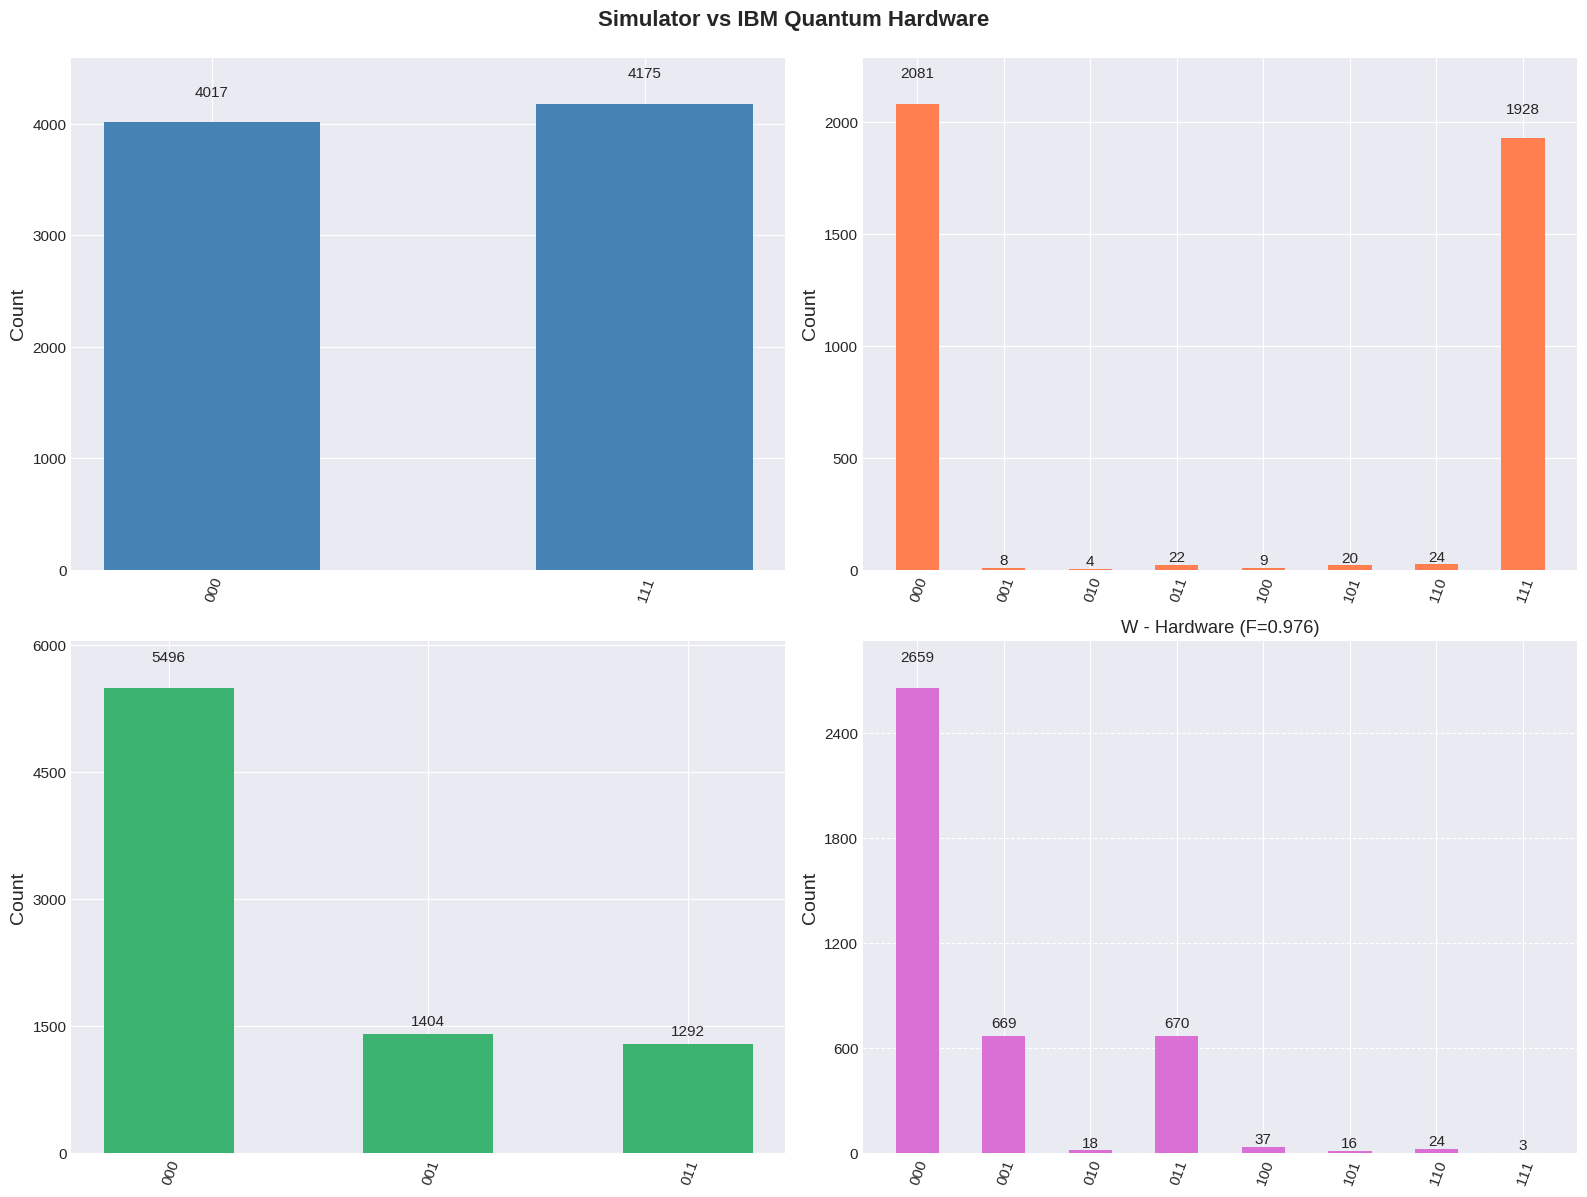


Spurious States Analysis (states >1% in hardware but absent in simulator)

GHZ State:
No significant spurious states (>1%)

W State:
No significant spurious states (>1%)

Detailed Comparison Table

State Fidelity Sim Purity HW Purity Degradation  Sim States  HW States
  GHZ   0.9780      2.000     0.979       51.1%           2          8
    W   0.9759      0.343     0.177       48.4%           3          8
Saved metrics to: comparison_metrics.csv

Top States Probability Comparison

GHZ State:
State      Simulator       Hardware        Diff
-------------------------------------------------------
|000⟩       98.07%         50.81%        -47.27%
|011⟩        0.00%          0.54%         +0.54%
|100⟩        0.00%          0.22%         +0.22%
|110⟩        0.00%          0.59%         +0.59%
|111⟩      101.93%         47.07%        -54.86%

W State:
State      Simulator       Hardware        Diff
-------------------------------------------------------
|000⟩      134.18%         64.92%    

In [17]:
# ============================================================================
# STEP 4: COMPREHENSIVE COMPARISON - SIMULATOR VS HARDWARE
# ============================================================================

print("\n" + "="*70)
print("STEP 4: Simulator vs Hardware Analysis")
print("="*70)

import json
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
import pandas as pd

# Load hardware results
with open('results_hardware.json', 'r') as f:
    results_hw = json.load(f)

# Ensure simulator results exist
try:
    counts_ghz
    counts_w
except NameError:
    print("\nSimulator results not found. Running simulations...")
    shots = SHOTS_SIMULATION
    simulator_backend = BACKEND_SIM

    counts_ghz = run_experiment(ghz_circuit, backend=simulator_backend, shots=shots)
    counts_w = run_experiment(w_circuit, backend=simulator_backend, shots=shots)
    print("Simulator results generated")

results_sim = {'GHZ': counts_ghz, 'W': counts_w}

def hellinger_fidelity(counts_sim, counts_hw):
    all_states = set(counts_sim.keys()) | set(counts_hw.keys())
    shots_sim = sum(counts_sim.values())
    shots_hw = sum(counts_hw.values())
    fidelity = sum(np.sqrt((counts_sim.get(s,0)/shots_sim) * (counts_hw.get(s,0)/shots_hw))
                   for s in all_states)
    return fidelity ** 2

print("\nFidelity Analysis (Simulator vs Hardware)")
fidelities = {}

for state_name in ['GHZ', 'W']:
    fid = hellinger_fidelity(results_sim[state_name], results_hw[state_name])
    fidelities[state_name] = fid
    print(f"\n{state_name} State:")
    print(f"Fidelity : {fid:.4f}")
    print(f"% Similarity : {fid*100:.2f}%")
    print(f"Deviation   : {(1-fid)*100:.2f}%")

# Plot histograms
print("\nGenerating comparison histograms...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Simulator vs IBM Quantum Hardware', fontsize=16, fontweight='bold', y=0.995)

plot_histogram(results_sim['GHZ'], ax=axes[0,0], title='GHZ - Simulator', color='steelblue')
plot_histogram(results_hw['GHZ'], ax=axes[0,1],
               title=f'GHZ - Hardware (F={fidelities["GHZ"]:.3f})', color='coral')

plot_histogram(results_sim['W'], ax=axes[1,0], title='W - Simulator', color='mediumseagreen')
plot_histogram(results_hw['W'], ax=axes[1,1],
               title=f'W - Hardware (F={fidelities["W"]:.3f})', color='orchid')

plt.tight_layout()
plt.savefig('comparison_simulator_vs_hardware.png', dpi=200, bbox_inches='tight')
print("Saved figure: comparison_simulator_vs_hardware.png")
plt.show()

# Spurious states
print("\nSpurious States Analysis (states >1% in hardware but absent in simulator)")

def find_spurious_states(counts_sim, counts_hw, threshold=0.01):
    total_hw = sum(counts_hw.values())
    return {s: c/total_hw for s, c in counts_hw.items() if s not in counts_sim and c/total_hw > threshold}

for state_name in ['GHZ', 'W']:
    spurious_states = find_spurious_states(results_sim[state_name], results_hw[state_name])
    print(f"\n{state_name} State:")
    if spurious_states:
        print(f"Spurious states detected: {len(spurious_states)}")
        for s, p in sorted(spurious_states.items(), key=lambda x: x[1], reverse=True)[:5]:
            print(f"|{s}⟩ : {p*100:.2f}%")
    else:
        print("No significant spurious states (>1%)")

# Detailed comparison table
print("\n" + "="*70)
print("Detailed Comparison Table")
print("="*70)

comparison_data = []
for state_name in ['GHZ', 'W']:
    sim_counts = results_sim[state_name]
    hw_counts = results_hw[state_name]

    expected_states = ['000','111'] if state_name=='GHZ' else ['001','010','100']

    sim_purity = sum(sim_counts.get(s,0) for s in expected_states)/shots
    hw_purity = sum(hw_counts.get(s,0) for s in expected_states)/shots

    comparison_data.append({
        'State': state_name,
        'Fidelity': f"{fidelities[state_name]:.4f}",
        'Sim Purity': f"{sim_purity:.3f}",
        'HW Purity': f"{hw_purity:.3f}",
        'Degradation': f"{(1-hw_purity/sim_purity)*100:.1f}%",
        'Sim States': len(sim_counts),
        'HW States': len(hw_counts)
    })

df_comparison = pd.DataFrame(comparison_data)
print("\n" + df_comparison.to_string(index=False))
df_comparison.to_csv('comparison_metrics.csv', index=False)
print("Saved metrics to: comparison_metrics.csv")

# Top states probability comparison
print("\nTop States Probability Comparison")

for state_name in ['GHZ', 'W']:
    print(f"\n{state_name} State:")
    print(f"{'State':<10} {'Simulator':<15} {'Hardware':<15} {'Diff'}")
    print(f"{'-'*55}")

    sim_counts = results_sim[state_name]
    hw_counts = results_hw[state_name]

    top_states = set(list(sim_counts.keys())[:5]) | set(list(hw_counts.keys())[:5])

    for s in sorted(top_states):
        sim_prob = sim_counts.get(s,0)/shots
        hw_prob = hw_counts.get(s,0)/shots
        diff = hw_prob - sim_prob
        print(f"|{s}⟩{'':<5} {sim_prob*100:>6.2f}%{'':<7} "
              f"{hw_prob*100:>6.2f}%{'':<7} {diff*100:>+6.2f}%")

print("\n" + "="*70)
print("STEP 4 COMPLETE - Simulator vs Hardware analysis done")
print("="*70)
